<a href="https://colab.research.google.com/github/ZachZaleski/ECGR-4090/blob/main/Part1_RTAI_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
cifar10 = datasets.CIFAR10(
    'data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting data/cifar-10-python.tar.gz to data


In [4]:
cifar10_val = datasets.CIFAR10(
    'data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [31]:
label_map = {6:0, 9: 1}
class_names = ['frog', 'horse', 'ship', 'truck']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [6, 9]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [6, 9]]

In [24]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [14]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [15]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [16]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


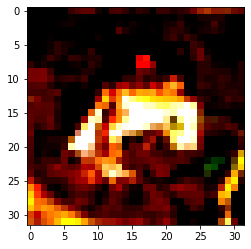

In [32]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [18]:
img_batch = img.view(-1).unsqueeze(0)

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [15]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [21]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [22]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [23]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [24]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [25]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [27]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [28]:
log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [30]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [31]:
loss = nn.NLLLoss()

In [32]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward>)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 4.854689
Epoch: 1, Loss: 4.496308
Epoch: 2, Loss: 1.698532
Epoch: 3, Loss: 6.565901
Epoch: 4, Loss: 9.524979
Epoch: 5, Loss: 6.006360
Epoch: 6, Loss: 5.335664
Epoch: 7, Loss: 13.375288
Epoch: 8, Loss: 1.479551
Epoch: 9, Loss: 2.397843
Epoch: 10, Loss: 4.263307
Epoch: 11, Loss: 6.935426
Epoch: 12, Loss: 14.914207
Epoch: 13, Loss: 0.002580
Epoch: 14, Loss: 7.726982
Epoch: 15, Loss: 0.077731
Epoch: 16, Loss: 0.378323
Epoch: 17, Loss: 8.452645
Epoch: 18, Loss: 2.489220
Epoch: 19, Loss: 4.116791
Epoch: 20, Loss: 1.715885
Epoch: 21, Loss: 3.215723
Epoch: 22, Loss: 2.981966
Epoch: 23, Loss: 6.080756
Epoch: 24, Loss: 0.744871
Epoch: 25, Loss: 5.307116
Epoch: 26, Loss: 11.053152
Epoch: 27, Loss: 0.320726
Epoch: 28, Loss: 6.800272
Epoch: 29, Loss: 7.307101
Epoch: 30, Loss: 4.908613
Epoch: 31, Loss: 4.487743
Epoch: 32, Loss: 7.859955
Epoch: 33, Loss: 3.328586
Epoch: 34, Loss: 0.017713
Epoch: 35, Loss: 0.126035
Epoch: 36, Loss: 4.639104
Epoch: 37, Loss: 8.709373
Epoch: 38, Loss: 7.

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200

t0 = time.time()
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

t1 = time.time()
TotalTime = t1 - t0
print("Total time: ", TotalTime)

Epoch: 0, Loss: 0.384462
Epoch: 1, Loss: 0.353788
Epoch: 2, Loss: 0.200041
Epoch: 3, Loss: 0.156123
Epoch: 4, Loss: 0.426598
Epoch: 5, Loss: 0.261545
Epoch: 6, Loss: 0.090307
Epoch: 7, Loss: 0.096493
Epoch: 8, Loss: 0.485101
Epoch: 9, Loss: 0.098792
Epoch: 10, Loss: 0.166920
Epoch: 11, Loss: 0.047117
Epoch: 12, Loss: 0.087907
Epoch: 13, Loss: 0.068003
Epoch: 14, Loss: 0.099627
Epoch: 15, Loss: 0.272643
Epoch: 16, Loss: 0.273304
Epoch: 17, Loss: 0.085520
Epoch: 18, Loss: 0.036159
Epoch: 19, Loss: 0.161434
Epoch: 20, Loss: 0.252739
Epoch: 21, Loss: 0.284020
Epoch: 22, Loss: 0.164493
Epoch: 23, Loss: 0.052477
Epoch: 24, Loss: 0.170513
Epoch: 25, Loss: 0.139089
Epoch: 26, Loss: 0.078529
Epoch: 27, Loss: 0.109175
Epoch: 28, Loss: 0.016699
Epoch: 29, Loss: 0.078620
Epoch: 30, Loss: 0.049674
Epoch: 31, Loss: 0.061634
Epoch: 32, Loss: 0.021411
Epoch: 33, Loss: 0.083561
Epoch: 34, Loss: 0.065011
Epoch: 35, Loss: 0.124322
Epoch: 36, Loss: 0.095827
Epoch: 37, Loss: 0.026431
Epoch: 38, Loss: 0.037

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 4))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 200

t2 = time.time()
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

t3 = time.time()
TotalTime2 = t3 - t2

print("Total Time ", TotalTime2)

Epoch: 0, Loss: 0.399629
Epoch: 1, Loss: 0.245768
Epoch: 2, Loss: 0.464472
Epoch: 3, Loss: 0.286197
Epoch: 4, Loss: 0.178700
Epoch: 5, Loss: 0.389373
Epoch: 6, Loss: 0.111758
Epoch: 7, Loss: 0.285861
Epoch: 8, Loss: 0.283264
Epoch: 9, Loss: 0.105488
Epoch: 10, Loss: 0.143113
Epoch: 11, Loss: 0.118356
Epoch: 12, Loss: 0.327182
Epoch: 13, Loss: 0.195282
Epoch: 14, Loss: 0.233161
Epoch: 15, Loss: 0.555178
Epoch: 16, Loss: 0.068058
Epoch: 17, Loss: 0.226802
Epoch: 18, Loss: 0.122006
Epoch: 19, Loss: 0.478116
Epoch: 20, Loss: 0.311386
Epoch: 21, Loss: 0.102034
Epoch: 22, Loss: 0.291841
Epoch: 23, Loss: 0.154104
Epoch: 24, Loss: 0.037736
Epoch: 25, Loss: 0.071566
Epoch: 26, Loss: 0.011297
Epoch: 27, Loss: 0.007362
Epoch: 28, Loss: 0.001962
Epoch: 29, Loss: 0.026436
Epoch: 30, Loss: 0.179711
Epoch: 31, Loss: 0.010974
Epoch: 32, Loss: 0.012241
Epoch: 33, Loss: 0.005659
Epoch: 34, Loss: 0.002868
Epoch: 35, Loss: 0.011540
Epoch: 36, Loss: 0.007471
Epoch: 37, Loss: 0.020421
Epoch: 38, Loss: 0.004